In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # noqa
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # noqa

In [2]:
import os
import sqlite3
from pathlib import Path

import datasets
import swifter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nfts.dataset
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-poster')

DATA_DIR = Path('/mnt/data/zp/nft-eda/data')

# Load data

Data from https://www.kaggle.com/simiotic/ethereum-nfts

In [3]:
bd = nfts.dataset.FromSQLite(DATA_DIR / 'nfts.sqlite')

# Tables
transfers_df = bd.load_dataframe("transfers")
transfers_df = transfers_df.sort_values('timestamp').reset_index(drop=True)

nfts_df =  bd.load_dataframe("nfts")
mints_df = bd.load_dataframe("mints")

transfers_df.shape, nfts_df.shape, mints_df.shape

((4514729, 9), (9388, 3), (6667282, 9))

##### Description of the dataset

In [4]:
nfts.dataset.explain()


The Moonstream NFTs dataset

To load the NFTs dataset from a SQLite file, run:
>>> ds = nfts.dataset.FromSQLite(<path to sqlite database>)

This dataset consists of the following dataframes:

Dataframe: nfts
Load using:
	nfts_df = ds.load_dataframe(<sqlite connection or path to sqlite db>, "nfts")

Describes the NFT contracts represented in this dataset, with a name and symbol if they were available at time of crawl.

Columns:
1. address: The Ethereum address of the NFT contract.
2. name: The name of the collection of NFTs that the contract represents.
3. symbol: The symbol of the collection of NFTs that the contract represents.

- - -

Dataframe: mints
Load using:
	mints_df = ds.load_dataframe(<sqlite connection or path to sqlite db>, "mints")

All token mint events crawled in this dataset.

Columns:
1. event_id: A unique event ID associated with the event.
2. transaction_hash: The hash of the transaction which triggered the event.
3. block_number: The transaction block in which the 

In [5]:
transfers_df.head()

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp
0,a996e537-0cd5-4862-b7e8-952901e624b2,0x40f4312461a1868a169a5dd16e44856e5e778f2a1b5b...,12150246,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,2067216718446828862151509780737619171783478638...,0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5,0x8072566Fcdbe9E1827C57A8091085a3095bd4cF0,5.749535e+15,1617235214
1,1dd3f4d2-b4eb-42a6-9e39-29f8bfeba19f,0x8723fa1d48917b0a47823d59ef83fc3db6aeac9eab5e...,12150249,0xF6C71e1e72254051F2e26270C16A84Fbd1dBFAfD,50,0xBb3f083C03bf3a9C6e807487F441d0680f7B6c81,0x9FF5ad420c4DAf1eeA5331081b5b5c07EF12D82C,0.000000e+00,1617235235
2,7e1e7f78-c793-4e97-a9e9-119719d85385,0xa7362de8036dfb5fac92db343aaed8a779e2753dce54...,12150249,0x60F80121C31A0d46B5279700f9DF786054aa5eE5,696112,0x1816359F9af8a725160BD51e2a25b1fbE6d5bB74,0xa1D3F6BF7dE7f968789e2C9F3CFDdD49cb01a30c,0.000000e+00,1617235235
3,0986b47d-8b7c-4db1-8d69-65847a48d757,0x346561b3f7a233c4245f91c68940b2d750df26ef1b04...,12150249,0xb932a70A57673d89f4acfFBE830E8ed7f75Fb9e0,16412,0x9f37284b3a538BE8EEa2d401B595f44C96D39B70,0xa353401738e7ec6A4db9C0ee4C66eB5252f681C4,0.000000e+00,1617235235
4,e96dcff0-19ec-4b43-bd34-f6b7e3a219fb,0x0e52745fbb33e6d8b49d672af16edc8660bb1d493565...,12150251,0x60F80121C31A0d46B5279700f9DF786054aa5eE5,696111,0x1816359F9af8a725160BD51e2a25b1fbE6d5bB74,0xB146CaD3eF5F6D929629A28ff432628E6Faf995C,0.000000e+00,1617235260


In [6]:
nfts_df.head()

,address,name,symbol
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR
3,0x511372B44231a31527025a3D273C1dc0a83D77aF,Maps Restored,MAP
4,0x2E956Ed3D7337F4Ed4316A6e8F2EdF74BF84bb54,Neon Junkies,JUNKIES


In [7]:
mints_df.head()

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp
0,6c6d226e-2096-4b50-ac3f-f7078ca3a0c2,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,3223,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933
1,263c923f-4db9-4d81-a547-27e1fe5ec405,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,5077,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933
2,8baa8502-42f9-453e-824a-ad504045c9c5,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,5070,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933
3,364ee658-ff31-4d0a-a7a7-60d3d7822772,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,3757,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933
4,58d3adc3-03d2-4e7b-b02c-47957c1f5752,0xd44be17c0298717ce001843069b0a2ca08b577fa2b33...,12936414,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,3252202771441387673917605047769619801375983664...,0x0000000000000000000000000000000000000000,0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5,2.251726e+15,1627776925


# Common Exploratory Data Analysis (EDA)

##### transaction_value

In [8]:
transfers_df['transaction_value'].describe()

count    4.514729e+06
mean     4.060893e+17
std      4.279892e+18
min      0.000000e+00
25%      0.000000e+00
50%      3.500000e+16
75%      1.999000e+17
max      2.275000e+21
Name: transaction_value, dtype: float64

In [9]:
transfers_df['transaction_value'].value_counts()

0.000000e+00    1766438
1.000000e+17      87061
5.000000e+16      65698
2.000000e+17      56579
1.500000e+17      54963
                 ...   
2.330861e+16          1
3.890310e+17          1
4.456375e+15          1
3.898900e+18          1
8.141655e+15          1
Name: transaction_value, Length: 100326, dtype: int64

The Ethereum NFTs dataset is constructed purely from events on the Ethereum blockchain. It does not include any data from Layer 2 networks like Polygon. Nor does it include any data from centralized APIs like the OpenSea API. It does not account for events or data from any non-ERC721 smart contracts associated with these platforms on the Ethereum blockchain.

This means that two parties could exchange a positive amount of funds for a transfer off-chain and conduct the transfer on-chain and we would not be able to distinguish the transfer from a gift.

So, make condition for not zero transaction value

In [10]:
cond_zero_transaction_value = transfers_df['transaction_value'] > 0
transfers_df[cond_zero_transaction_value]['transaction_value'].describe()

count    2.748291e+06
mean     6.670994e+17
std      5.469620e+18
min      1.000000e+00
25%      5.000000e+16
50%      1.420000e+17
75%      3.980000e+17
max      2.275000e+21
Name: transaction_value, dtype: float64

In [11]:
transfers_df[cond_zero_transaction_value]['transaction_value'].value_counts()

1.000000e+17    87061
5.000000e+16    65698
2.000000e+17    56579
1.500000e+17    54963
3.000000e+16    54577
                ...  
8.147700e+19        1
4.906676e+16        1
9.590782e+15        1
3.297236e+16        1
2.056374e+16        1
Name: transaction_value, Length: 100325, dtype: int64

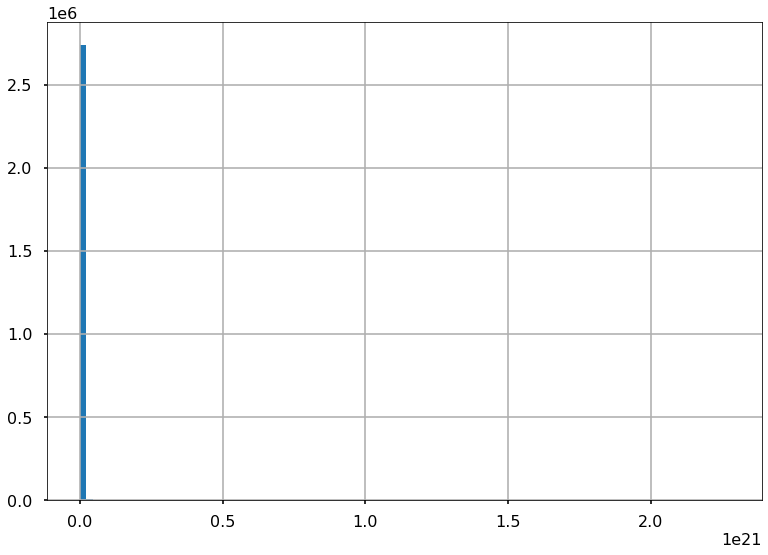

In [12]:
transfers_df[cond_zero_transaction_value]['transaction_value'].hist(bins=100)

In [13]:
transfers_df['timestamp'].describe()

count    4.514729e+06
mean     1.628318e+09
std      3.695920e+06
min      1.617235e+09
25%      1.626588e+09
50%      1.629496e+09
75%      1.630983e+09
max      1.632587e+09
Name: timestamp, dtype: float64

# Experiment

I got bored and decided to try to train a transformer for price prediction (I choose gpt2 ). 

# Train GPT2

#### Data preprocessing 

Find min value gap for digitizing

In [14]:
transaction_values = transfers_df['transaction_value'].unique()
transaction_values.sort()
value_dif = np.diff(transaction_values)

value_dif.min(), value_dif.max()

(1.0, 7.9999901e+20)

The difference is too big, let's make an ID for each value

In [15]:
value_id_map = {v: i for i, v in enumerate(transaction_values)}
value_id_map_back = {v: k for k, v in value_id_map.items()}

len(value_id_map)

100326

Transform all values to ids

In [16]:
transfers_df['value_id'] = transfers_df['transaction_value'].swifter.apply(lambda x: value_id_map[x])

Dask Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Find min timestamp gap for digitizing

In [17]:
timestamp_values = transfers_df['timestamp'].unique()
timestamp_values.sort()
timestamp_dif = np.diff(timestamp_values)

timestamp_dif.min(), timestamp_dif.max()

(1, 2337)

min 1, so we will do prediction for every time point

How many rows for every token? We don't need < 1

In [18]:
df = transfers_df.groupby('token_id').size().reset_index()
df

,token_id,0
0,0,1774
1,1,2823
2,10,1354
3,100,710
4,1000,396
...,...,...
721027,9999993887679348490756749059491113043892314138...,1
721028,9999994873304983994459633559655439607312002830...,2
721029,9999996075365696952295635974078671937655187316...,1
721030,999999999,4


In [19]:
cond_greater_1 = df[0] > 1
token_id_ls = df[cond_greater_1]['token_id'].values

len(token_id_ls)

300460

#### Split token history to dataset

In [20]:
BLOCK_SIZE = 256
PADDING_ID = len(value_id_map)

input_ids_all = list()
# TODO remove 10
for token_id in tqdm(token_id_ls[:100000], desc='Transform value ids'):
    cond_gr = transfers_df['token_id'] == token_id
    gr = transfers_df[cond_gr].copy()
    timestamps = gr['timestamp'].values
    value_ids = gr['value_id'].values
    
    n = len(value_ids)
    q, r = divmod(n, BLOCK_SIZE)

    value_ids = np.pad(value_ids, (BLOCK_SIZE - r, 0), 'constant', constant_values=PADDING_ID)
    value_ids = value_ids.reshape(q + 1, BLOCK_SIZE)
    input_ids_all.append(value_ids)
    
input_ids_all = np.vstack(input_ids_all)
input_ids_all.shape

Transform value ids: 100%|██████████| 100000/100000 [9:07:41<00:00,  3.04it/s] 


(101449, 256)

Split data on train and validation parts

In [21]:
indices = np.random.permutation(input_ids_all.shape[0])
train_part = int(len(indices) * 0.8)
training_idx, test_idx = indices[:train_part], indices[train_part:]
train_input_ids, test_input_ids = input_ids_all[training_idx,:], input_ids_all[test_idx,:]

train_input_ids.shape, test_input_ids.shape

((81159, 256), (20290, 256))

### Create dataset 

In [22]:
from transformers import TextDataset, DataCollatorForLanguageModeling

class NftDataset(Dataset):

    def __init__(self, array):
        self.array = array
        
    def __len__(self):
        return len(self.array)

    def __getitem__(self, idx):
        input_ids = self.array[idx]
        input_ids = torch.from_numpy(input_ids)
        
        x = {
            'input_ids': input_ids,
            'labels': input_ids.clone()
            }

        return x

In [23]:
train_dataset = NftDataset(train_input_ids)
test_dataset = NftDataset(test_input_ids)

# Model

I cannot train a big model from scratch, so I made a tiny version of GPT2.

In [25]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

bos_token_id = len(value_id_map) + 2
eos_token_id = len(value_id_map) + 2

config = GPT2Config(
    vocab_size=len(value_id_map) + 3,
    n_positions=512,
    n_embd=128,
    n_layer=2,
    n_head=4,
    n_ctx=1024,
    bos_token_id=bos_token_id,
    eos_token_id=eos_token_id,
    architectures=["GPT2LMHeadModel"],
    task_specific_params= {
        "text-generation": {
          "do_sample": True,
          "max_length": 50
        }
      },
    summary_type='cls_index',
)

model = GPT2LMHeadModel(config)

### Calcullate number parameters

In [26]:
def count_parameters(model):
    table = list()
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.append({'Module': name, 'Parameters': param})
        total_params += param
    
    table = pd.DataFrame(table)
    print(f"Total Trainable Params: {total_params}")
    return table
    
count_parameters(model)

Total Trainable Params: 13304448


,Module,Parameters
0,transformer.wte.weight,12842112
1,transformer.wpe.weight,65536
2,transformer.h.0.ln_1.weight,128
3,transformer.h.0.ln_1.bias,128
4,transformer.h.0.attn.c_attn.weight,49152
5,transformer.h.0.attn.c_attn.bias,384
6,transformer.h.0.attn.c_proj.weight,16384
7,transformer.h.0.attn.c_proj.bias,128
8,transformer.h.0.ln_2.weight,128
9,transformer.h.0.ln_2.bias,128


In [27]:
config

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 100328,
  "embd_pdrop": 0.1,
  "eos_token_id": 100328,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 128,
  "n_head": 4,
  "n_inner": null,
  "n_layer": 2,
  "n_positions": 512,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.13.0",
  "use_cache": true,
  "vocab_size": 100329
}

# Train model

In [33]:
from transformers import Trainer, TrainingArguments,AutoModelWithLMHead, default_data_collator

OUTPUT_DIR = '/mnt/data/zp/nft-eda/experiments/gpt_nft_v0'

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved 
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    
    do_train=True,
    )


trainer = Trainer(
    model=model,
    args=training_args,
#     data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [34]:
trainer.train()

***** Running training *****
  Num examples = 81159
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 60870


Step,Training Loss
500,8.119000
1000,2.298500
1500,0.203300
2000,0.192800
2500,0.191900
3000,0.170700
3500,0.176600
4000,0.178800
4500,0.166900
5000,0.175700


Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-800
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-800/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-800/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-1600
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-1600/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-1600/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-2400
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-2400/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-2400/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-3200
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/

Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-24000
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-24000/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-24000/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-24800
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-24800/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-24800/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-25600
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-25600/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-25600/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-26400
Configuration saved in /mnt/data/zp/nft-eda/experiment

Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-47200
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-47200/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-47200/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-48000
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-48000/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-48000/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-48800
Configuration saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-48800/config.json
Model weights saved in /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-48800/pytorch_model.bin
Saving model checkpoint to /mnt/data/zp/nft-eda/experiments/gpt_nft_v0/checkpoint-49600
Configuration saved in /mnt/data/zp/nft-eda/experiment

TrainOutput(global_step=60870, training_loss=0.24805982736055146, metrics={'train_runtime': 3398.4143, 'train_samples_per_second': 71.644, 'train_steps_per_second': 17.911, 'total_flos': 148395530649600.0, 'train_loss': 0.24805982736055146, 'epoch': 3.0})

# Show result

In [52]:
# Load model from checkpoint if need
# model_dir = ''
# model = GPT2LMHeadModel.from_pretrained(model_dir)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(100329, 128)
    (wpe): Embedding(512, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [265]:
i = 37
x = test_input_ids[i: i + 1]

with torch.no_grad():
    # Prdict after 128 value
    pred = model.generate(torch.from_numpy(x[0:1, :128]).cuda(), 
                          max_length=256, 
                          repetition_penalty=1.1, 
                          output_scores=True,
                          return_dict_in_generate=True,
                         )

Setting `pad_token_id` to `eos_token_id`:100328 for open-end generation.


Encode

In [266]:
def encode(sequence):
    return [value_id_map_back.get(i, 0) for i in sequence]

x_values = encode(x[0])
pred_values = encode(pred['sequences'][0].cpu().numpy())

len(x_values), len(pred_values)

(256, 256)

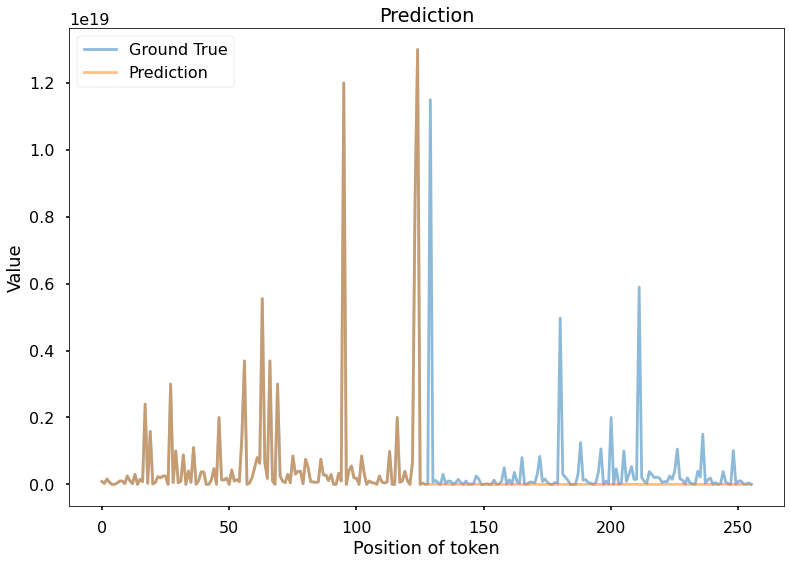

In [270]:
plt.title("Prediction")
plt.xlabel("Position of token")
plt.ylabel("Value")

plt.plot(x_values, alpha=0.5, label="Ground True");
plt.plot(pred_values, alpha=0.5, label="Prediction");

plt.legend(loc="upper left")

# Summary

The result is not perfect :) but that's all I did in three evenings after work. 

what could be the reason for the fiasco:
1. More data.
2. Model too simple, 13m parameters vs GPT2 125m.
3. I used a default Position encoding, but in our data we have another scale.
4. Tokens huge imbalance. 
5. More loss regulization.